# Predicting Loan Repayment

In this notebook we analyze loans and attempt to predict if a loan will be repaid or not. The data is analyzed and a
binary classification model is tuned using XGboost giving approximately 92.3% accuracy on our test dataset.

In [644]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
#loan_table = pd.read_csv("https://raw.githubusercontent.com/Sarleo/Bank-loan-prediction/master/loan_table.csv")
#borrower_table = pd.read_csv("https://raw.githubusercontent.com/Sarleo/Bank-loan-prediction/master/borrower_table.csv")

In [645]:
loan_table = pd.read_csv("loan_table.csv")
borrower_table = pd.read_csv("borrower_table.csv")
loan_table = loan_table[loan_table.columns[1:]]
borrower_table = borrower_table[borrower_table.columns[1:]]

## Problem Formulation
1. We have to join the loan and borrower tables, this gives us the borrower and loan info for each transaction
2. Next we select only those transaction that were granted, since ungranted requests have no opportunity to be repaid
3. We wish to predict the "loan_repaid" column using the various other features.

In [498]:
df = pd.merge(left = loan_table, right = borrower_table, on="loan_id",how= "left")
df = df[df.loan_repaid.isnull().astype(int) == 0]
df = df[df["loan_granted"] == 1]

## Visualization

1. Investigate some of the features and their effects
2. Look at the  breakdown of Loan Purpose (business, investment, etc.)
3. Look at the proportion of repayment of each Loan category

Text(0.5, 1.0, 'Proportion of Loans Repaid by Purpose')

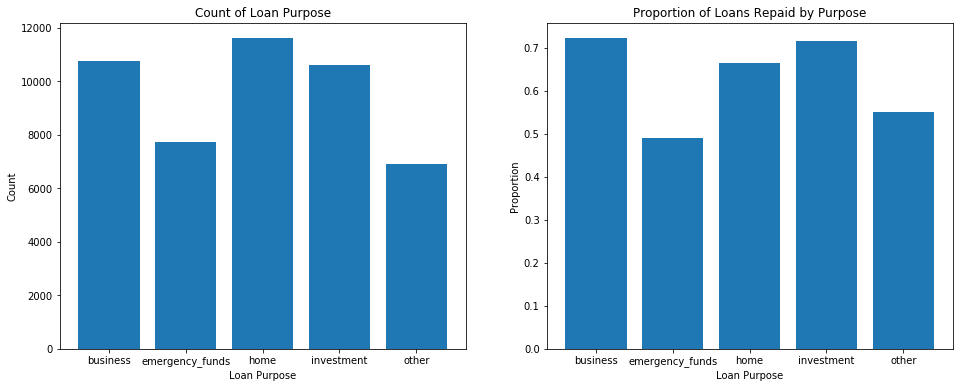

In [499]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
loan_purpose_counts = pd.DataFrame(df.groupby("loan_purpose").size()).reset_index()
loan_purpose = loan_purpose_counts[loan_purpose_counts.columns[0]]
count = loan_purpose_counts[loan_purpose_counts.columns[1]]
repaid = df[df["loan_repaid"]== 1].groupby("loan_purpose").size().values
proportion = repaid/count
ax[0].bar(loan_purpose, count)
ax[0].set_xlabel("Loan Purpose")
ax[0].set_ylabel("Count")
ax[0].set_title("Count of Loan Purpose")
ax[1].bar(loan_purpose,proportion)
ax[1].set_xlabel("Loan Purpose")
ax[1].set_ylabel("Proportion")
ax[1].set_title("Proportion of Loans Repaid by Purpose")

## Visualization

1. We plot a histogram of savings amounts for both repaid and non repaid loans
2. Next we plot the mean probability of repayment by credit limit, we select 100 credit limit bucket
3. The trend shows a strong relationship between credit limit and probability of repayment

In [500]:
credit_limits = sorted(df["total_credit_card_limit"].unique())
#plt.plot(df.groupby("total_credit_card_limit").size())
x = np.linspace(0,max(credit_limits),100)
average_repayment = []
for i in range(len(x)-1):
    vals = df[(df["total_credit_card_limit"]>=x[i]) & (df["total_credit_card_limit"]<x[i+1])]
    if len(vals) == 0:
        average_repayment.append(None)
        continue
    prop = sum(vals["loan_repaid"])/len(vals)
    average_repayment.append(prop)
average_repayment = pd.DataFrame(np.array(average_repayment).astype(float)).interpolate("linear")
x = x[:-1]
average_repayment = average_repayment[average_repayment.columns[0]].values


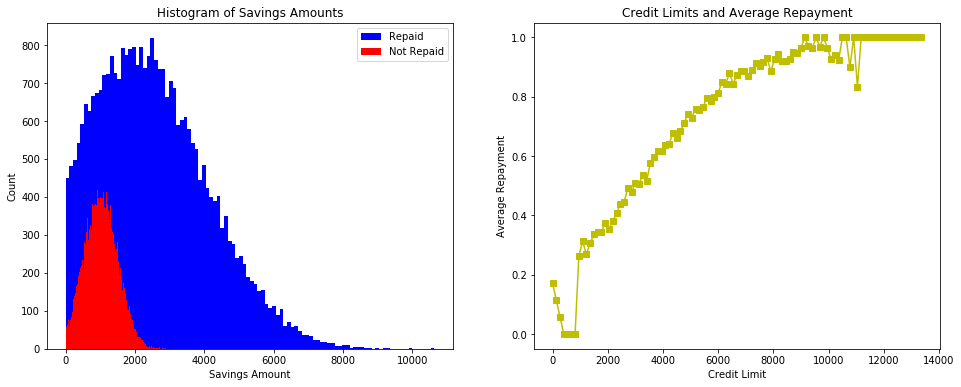

In [501]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax[0].hist(df[df.loan_repaid == 1]["saving_amount"],bins=100,color='blue',label="Repaid")
ax[0].hist(df[df.loan_repaid == 0]["saving_amount"],bins=100,color='red', label = "Not Repaid")
ax[0].set_xlabel("Savings Amount")
ax[0].set_ylabel("Count")
ax[0].set_title("Histogram of Savings Amounts")
ax[0].legend()
ax[1].plot(x,average_repayment,'ys-')
ax[1].set_xlabel("Credit Limit")
ax[1].set_ylabel("Average Repayment")
ax[1].set_title("Credit Limits and Average Repayment")
plt.show()


## Visualization

Finally we plot the correlation between our features and loan repayment, here we notice that certain variables such as age, fully repaid loans, first loan are not particularly indicative of a loan being repaid or not. 

However quantitative features indicating financial responsibility such as salary, checkings and savings amount and credit limit are particularly strongly correlated.

<BarContainer object of 11 artists>

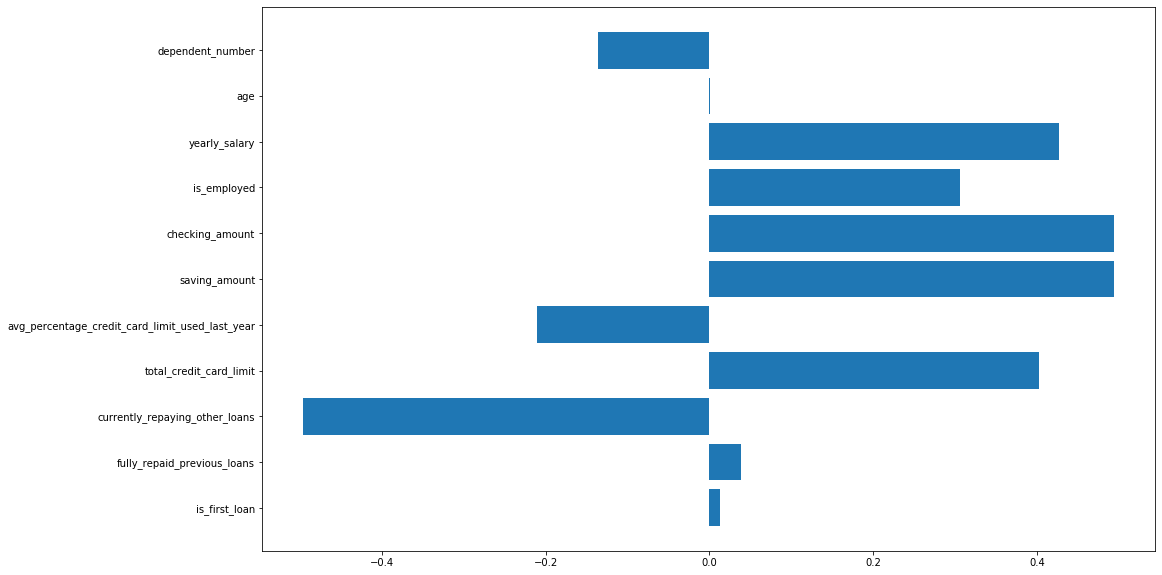

In [502]:
corrs= df.corr()["loan_repaid"]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))
features = list(corrs.index)
ax.barh(features[3:],corrs[3:])

## Feature Engineering 

Now we move on to feature engineering, the loan purpose is encoded into integers for use within our desired model (XGBoost) 
Additionally we will missing "NaN" values with 0 values since we assume that if there is nonexistent information regarding prior loan information then the applicant is equally risky as one indicating negative information. Another option here would be to assign a 0.5 for missing values. 

Next we shuffle our dataframe and drop the irrelevant features 'loan_id', 'age', 'is_employed', 'date', 'loan_repaid',  'loan_purpose. We posit that since salary and is_employed are strongly correlated we can drop the latter feature for improved model simplicity. We split our dataframe using an 80/20 split. 

In [634]:
#Feature Engineering
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(df["loan_purpose"])
encoded = label_encoder.transform(df["loan_purpose"])
df["loan_purpose_encoded"] = encoded
df["fully_repaid_previous_loans"] = df["fully_repaid_previous_loans"].fillna(value=0)
df["currently_repaying_other_loans"] = df["currently_repaying_other_loans"].fillna(value =0 )
df["avg_percentage_credit_card_limit_used_last_year"] = df["avg_percentage_credit_card_limit_used_last_year"].fillna(value=0)

In [635]:
df.sample(frac=1)
Y = df["loan_repaid"].astype(int)
X = df.drop(['loan_id','age','is_employed','date','loan_repaid','loan_purpose'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

## XGBoost

We decided to use XGBoost for binary classification (0 is defaulted loan and 1 is repaid loan). Since we are examining loan data we have an imbalanced dataset so it is required to scale the positive values (using ~0.5). Additionally there are a variety of parameters related to tree structure and regularization that we can tune. We construct a set of params and then test the accuracy of each iteration on our test set. 

In [343]:
#We have an imbalanced dataset so we need to scale the positive weights
pos = sum(y_train)
neg = len(y_train) - pos
scale_pos_weight = neg/ pos
scale_pos_weight

0.55642198089328

In [335]:
params = {"eval_metric" : ["logloss","error"], "learning_rate" : np.linspace(0.05,0.25,3), 
         "max_depth" : [5,8], "subsample" : np.linspace(0.5,1,3), "colsample_bytree" : np.linspace(0.5,1,3),
         "colsample_bylevel" : np.linspace(0.5,1,2), "scale_pos_weight" : np.linspace(0.5,0.6,2)}

In [336]:
import itertools
paramset = [list(params[p]) for p in params]
paramnames = [p for p in params]
paramset = list(itertools.product(*paramset))

In [306]:
best_acc = 0
best_params = []

In [307]:
for i in range(len(paramset)):
    v = paramset[i]
    xgb_class = xgb.XGBClassifier(objective='binary:logistic',n_estimators=10, gamma=0.1, use_label_encoder=False ,eval_metric=v[0],learning_rate=v[1],
                             max_depth=v[2], subsample = v[3], colsample_bytree= v[4], colsample_bylevel = v[5], scale_pos_weight = v[6])
    xgb_class.fit(X_train,y_train)
    pred = xgb_class.predict(X_test)
    accuracy = accuracy_score(y_test,pred)
    if accuracy > best_acc:
        best_acc = accuracy
        best_params = v
    print(v,accuracy)

('logloss', 0.05, 5, 0.5, 0.5, 0.5, 0.5) 0.8987514426607911
('logloss', 0.05, 5, 0.5, 0.5, 0.5, 0.6) 0.908089392508656
('logloss', 0.05, 5, 0.5, 0.5, 1.0, 0.5) 0.9079844717238484
('logloss', 0.05, 5, 0.5, 0.5, 1.0, 0.6) 0.9165879760780611
('logloss', 0.05, 5, 0.5, 0.75, 0.5, 0.5) 0.9119714615465324
('logloss', 0.05, 5, 0.5, 0.75, 0.5, 0.6) 0.9178470254957507
('logloss', 0.05, 5, 0.5, 0.75, 1.0, 0.5) 0.909663204280768
('logloss', 0.05, 5, 0.5, 0.75, 1.0, 0.6) 0.9146994019515265
('logloss', 0.05, 5, 0.5, 1.0, 0.5, 0.5) 0.9013744622809778
('logloss', 0.05, 5, 0.5, 1.0, 0.5, 0.6) 0.9042073234707796
('logloss', 0.05, 5, 0.5, 1.0, 1.0, 0.5) 0.9002203336480957
('logloss', 0.05, 5, 0.5, 1.0, 1.0, 0.6) 0.9004301752177106
('logloss', 0.05, 5, 0.75, 0.5, 0.5, 0.5) 0.8977022348127164
('logloss', 0.05, 5, 0.75, 0.5, 0.5, 0.6) 0.9052565313188543
('logloss', 0.05, 5, 0.75, 0.5, 1.0, 0.5) 0.9110271744832651
('logloss', 0.05, 5, 0.75, 0.5, 1.0, 0.6) 0.916797817647676
('logloss', 0.05, 5, 0.75, 0.75, 0.

In [329]:
best_acc, best_params

(0.9225684608120869, ('logloss', 0.25, 8, 0.75, 0.75, 1.0, 0.6))

## XGBoost

We arrive at an optimal set of hyperparameters giving an accuracy of 0.922 over our test set. We plot the feature importance according to this model below. To further improve our model we could do the following. 

1. Investigate most important features and further improve feature engineering 
2. Better/Different regularization and hyperparameter tuning (more hyperparameters could give incremental gains)
3. Cross Validation (utilize Cross Validation to get a more generalizable model) 
4. Investigate data points that were incorrectly classified (if one class dominates then we may make gains by simply making model more/less conservative.

In [636]:
v = list(('logloss', 0.25, 8, 0.75, 0.75, 1.0, 0.6))
xgb_class = xgb.XGBClassifier(objective='binary:logistic',n_estimators=100, gamma=0.1, use_label_encoder=False ,eval_metric=v[0],learning_rate=v[1],
                             max_depth=v[2], subsample = v[3], colsample_bytree= v[4], colsample_bylevel = v[5], scale_pos_weight = v[6])
xgb_class.fit(X_train,y_train)
pred = xgb_class.predict(X_test)
accuracy = accuracy_score(y_test,pred)
print(accuracy)

0.9226733815968944


<BarContainer object of 10 artists>

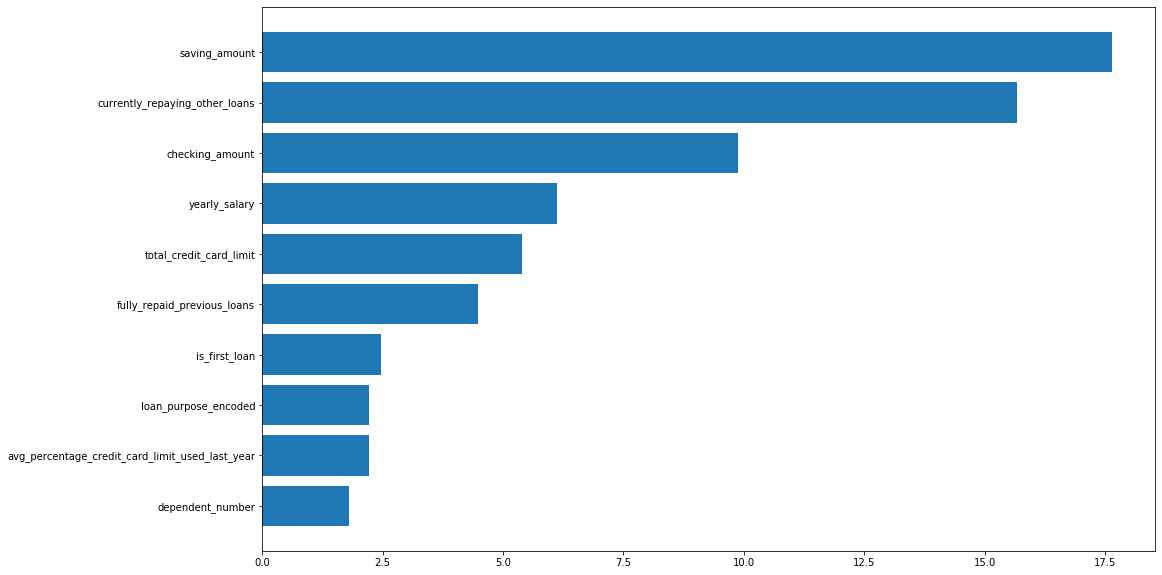

In [637]:
feature_importance = xgb_class.get_booster().get_score(importance_type="gain")
feature_importance = pd.Series(feature_importance).sort_values()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))
ax.barh(list(feature_importance.index), feature_importance)

## Improving the Model

1. We examine the specific datapoints that were incorrectly classified
2. We are more interested in trying to reduce the errors where y_test == 0  but pred == 1 (bad loans vs being too conservative)

In [638]:
test_proportions = pd.DataFrame(y_test).groupby("loan_repaid").size()/(len(y_test))
errors = np.where(y_test.values != pred)[0]
proportion_incorrect = df.iloc[errors].groupby("loan_repaid").size()/len(errors)
features_names, counts = list(proportion_incorrect.index), proportion_incorrect.values

In [639]:
def plot_series(df, size = (10,10), fig_type = 'bar'):
    if fig_type == 'bar':
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize= size)
        features = list(df.index)
        vals = df.values
        ax.bar(features,vals)
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1,figsize=size)
        ax.hist(df.values)

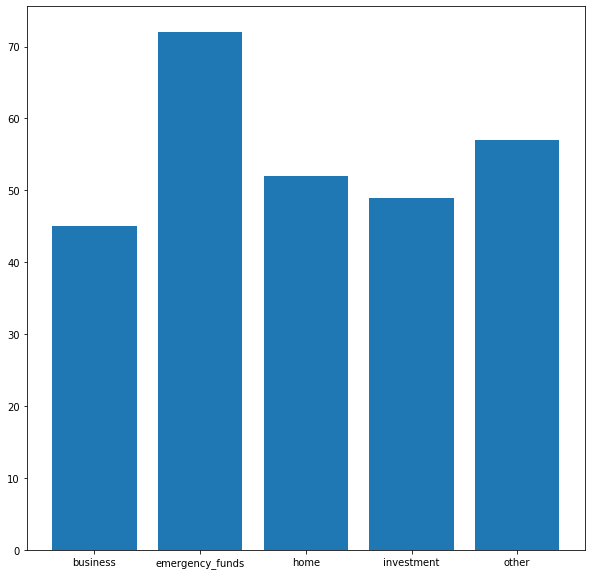

In [462]:
bad_loans = df.iloc[errors]
bad_loans = bad_loans[bad_loans.loan_repaid == 0]
bad_loans.groupby("loan_purpose").size()
plot_series(bad_loans.groupby("loan_purpose").size())
#this is concerning..it indicates we made too many loans for emergency funds, perhaps our encoding is ineffective

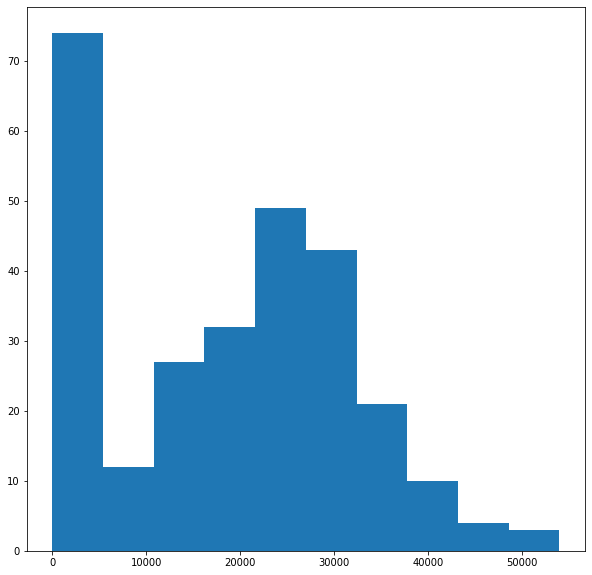

In [472]:
plot_series(bad_loans["yearly_salary"],fig_type='hist')

#Again we are making too many bad loans on individuals who have salary = 0, perhaps we could weight this more strongly
#By setting salary = 0 -> salary = -10000

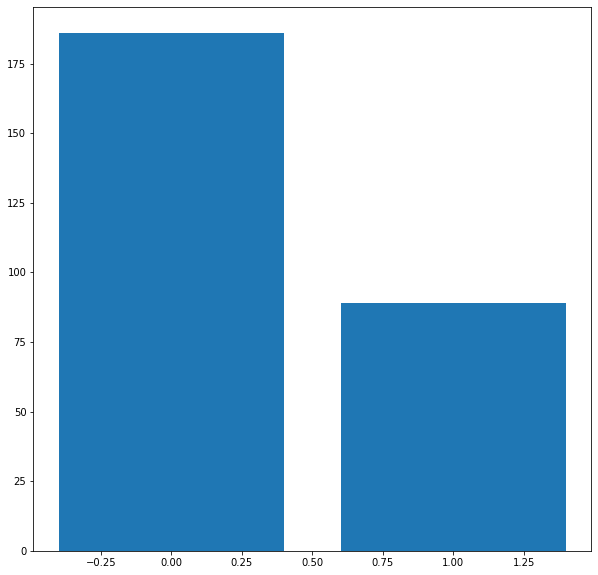

In [515]:
plot_series(bad_loans.groupby("currently_repaying_other_loans").size(),fig_type='bar')

To update
1. FIX Encoding of loan_purpose (this can be ordinal) emergency, other, home, investment, business     ->
2. FIX If yearly salary == 0 then set yearly salary = -10000
3. FIX Add in is_employed feature
4. FIX Currently_Repaying_other_loans if NAN this feature should be 1 instead of 0 since lack of info is risky


In [609]:
df2 = df.copy()

In [610]:
encoding = {"emergency_funds": -2, "other": 1, "home":2 , "investment":3, "business":4}
def encoding_func(x):
    return encoding[x]
def moving_zero(x):
    if x == 0:
        return -100000
    else:
        return x
df2["loan_purpose"] = list(map(encoding_func, df2["loan_purpose"].values))
df2["currently_repaying_other_loans"] = df["currently_repaying_other_loans"].fillna(value=0)
df2["avg_percentage_credit_card_limit_used_last_year"] = df2["avg_percentage_credit_card_limit_used_last_year"].fillna(value=0)
df2["fully_repaid_previous_loans"] = df["fully_repaid_previous_loans"].fillna(value=0)
df2["yearly_salary"] = list(map(moving_zero,df2["yearly_salary"]))

In [619]:
Y = df2["loan_repaid"].astype(int)
X = df2.drop(['loan_id','age','is_employed','date','loan_repaid'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

In [621]:
#We play around a bit with the hyperparameters
v = list(('logloss', 0.25, 5, 1,1, 1.0, 0.6))
xgb_class = xgb.XGBClassifier(objective='binary:logistic',n_estimators=100, gamma=0.1,use_label_encoder=False ,eval_metric=v[0],learning_rate=v[1],
                             max_depth=v[2], subsample = v[3], colsample_bytree= v[4], colsample_bylevel = v[5], scale_pos_weight = v[6])
xgb_class.fit(X_train,y_train)
pred = xgb_class.predict(X_test)
accuracy = accuracy_score(y_test,pred)
print(accuracy)

0.9230930647361242


<BarContainer object of 10 artists>

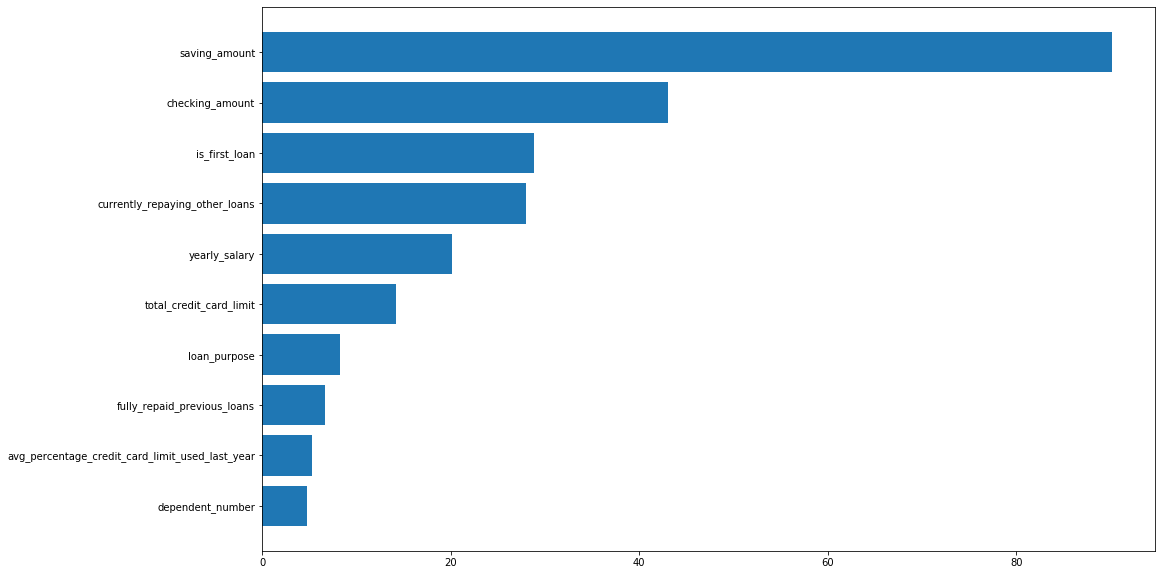

In [622]:
feature_importance = xgb_class.get_booster().get_score(importance_type="gain")
feature_importance = pd.Series(feature_importance).sort_values()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))
ax.barh(list(feature_importance.index), feature_importance)

## Summary

After investigating the borrower/loan dataset we constructed a deeper intuition behind the features and
came up with ways to fill missing values and encode categorical features. 

After this we performed hyperparameter tuning on a variety of hyperparameters used in XGBoost 

We constructed a model and then iterated on it, but alteration regarding feature engineering and further hyperparameter tuning
will only take us so far. It seems that the hard financial features are the strongest indicators of a loan being repaid, namely savings amounts and other direct proxies of financial ability and responsibility. 

Further improvements to this model could be made however large improvements could be made with additional feature sets regarding both the loan (loan amount, type of financing) as well as the user (martial status, education, etc).